<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/word2vec/SkipGram/SkipGram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir("drive/Udacity/RNN/word2vec-embeddings/")
!ls

sample_data
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0

In [2]:
!ls

text8  utils.py


## Loading Data

In [3]:
# read in the extracted text file      
with open('text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])
print(len(text))

 anarchism originated as a term of abuse first used against early working class radicals including t
100000000


## Pre-processing

In [4]:
import re
from collections import Counter

In [5]:
def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [6]:
#get list of words
words = preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [7]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


## Dictionaries

In [8]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [9]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
print(words[:100])
print(vocab_to_int)
print(int_to_vocab)

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']
{'the': 0, 'of': 1, 'and': 2, 'one': 3, 'in': 4, 'a': 5, 'to': 6, 'zero': 7, 'nine': 8, 'two': 9, 'is

In [10]:
int_words = [vocab_to_int[word] for word in words]
print(len(words))
print(len(int_words))

16680599
16680599


In [11]:
for xx, yy in zip(words[:10],int_words[:10]):
  print(xx,"--",yy)

anarchism -- 5233
originated -- 3080
as -- 11
a -- 5
term -- 194
of -- 1
abuse -- 3133
first -- 45
used -- 58
against -- 155


## Subsampling

In [12]:
from collections import Counter
import random
import numpy as np

In [13]:
threshold = 1e-5
word_counts = Counter(int_words)
print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

(5233, 303)


In [14]:
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
print(freqs)

{5233: 1.8164815304294527e-05, 3080: 3.4291334501836536e-05, 11: 0.007902294156223047, 5: 0.01953604903516954, 194: 0.00043277822337195443, 1: 0.035590868169662254, 3133: 3.375178553240204e-05, 45: 0.0017271562010452981, 58: 0.0013630805464480023, 155: 0.0005054974344746253, 127: 0.0006098102352319602, 741: 0.00013614618995396987, 476: 0.0002045490093011648, 10571: 6.954186717155661e-06, 133: 0.0005774972469513834, 0: 0.06363056866243233, 27349: 1.4987471373180303e-06, 102: 0.0007114852410276154, 854: 0.00012163831766473134, 2: 0.02497686084294695, 15067: 4.076592213505042e-06, 58112: 3.5969931295632727e-07, 150: 0.0005237221996644125, 3580: 2.8835894921998903e-05, 10: 0.010980001377648369, 190: 0.0004423102551652971, 4: 0.022313407330276328, 10712: 6.834286946170219e-06, 214: 0.00038565761337467557, 6: 0.018966704972645167, 1324: 8.105224518615908e-05, 104: 0.0007075884984705885, 454: 0.0002099444989955097, 19: 0.0065651119603079, 2731: 3.9147275226746954e-05, 362: 0.00024969127307718

In [15]:
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
print(p_drop)

{5233: 0.25803314192489146, 3080: 0.4599825339524992, 11: 0.9644267615025448, 5: 0.9773753623879587, 194: 0.8479917006734952, 1: 0.9832378119313352, 3133: 0.45568334430257695, 45: 0.9239088422795724, 58: 0.9143476584471071, 155: 0.8593497455736082, 127: 0.8719431999366315, 741: 0.7289825504731466, 476: 0.778893601917191, 10571: -0.19915915224535286, 133: 0.8684093473492618, 0: 0.9874637657774047, 27349: -1.5830678659299684, 102: 0.8814457705299201, 854: 0.7132755043218617, 2: 0.9799907379071721, 15067: -0.5662149484364791, 58112: -4.272665202090242, 150: 0.8618186254884372, 3580: 0.4111112159329233, 10: 0.9698214198790636, 190: 0.8496385533068163, 4: 0.9788301854663046, 10712: -0.20963235679130676, 214: 0.8389728726654947, 6: 0.9770382990950545, 1324: 0.6487490761030492, 104: 0.8811197752484013, 454: 0.7817532675894523, 19: 0.9609717631821799, 2731: 0.49458371591885264, 362: 0.7998763947382689, 3672: 0.401708458826014, 708: 0.7349270180451688, 371: 0.797479619423606, 26: 0.952307165547

In [16]:
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[5233, 11, 3133, 10571, 27349, 854, 15067, 58112, 854, 10712, 104, 454, 2731, 362, 708, 2757, 7088, 5233, 27, 320, 44611, 2877, 5233, 1134, 8983, 6437, 1818, 19, 4860, 6753]


## Making batches

In [17]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [18]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [0, 1, 2, 3, 4, 6, 7, 8, 9]


## Generating Batches

In [19]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [20]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]


## Building the graph

In [21]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

## SkipGram model

In [22]:
import torch
from torch import nn
import torch.optim as optim

In [23]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

## Training

In [24]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

however | feeders, autobiographical, drukqs, echoed, enforced
into | afonso, coaling, maximillian, pvt, rathdown
have | leopardi, inman, incredibles, pagemaker, soprano
be | processional, upstate, vote, clifton, avercamp
over | interlocutor, ivar, ruthless, ankobra, kam
a | wayside, marvellous, friedmann, carmine, burials
time | filamentous, baptizing, riel, gillette, roles
four | malatesta, overijssel, deceased, fullerene, contests
file | fnl, anachronisms, monarchies, algebra, aspire
institute | hypothyroidism, gtpases, dramatised, solanaceae, retraction
placed | werther, milah, knack, luxuriant, vampira
alternative | weeds, intact, craps, valletta, ovum
construction | outweigh, meanwhile, uncultivated, coup, niggle
additional | admits, beckhams, grizzly, fulbright, thunder
discovered | wto, frustration, great, georgia, manpower
freedom | queensland, tutor, beac, edge, mechanistic
...
time | filamentous, baptizing, gillette, riel, combatants
have | leopardi, inman, incredibles, pagem

## Visualizing the word vectors

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [26]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [27]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

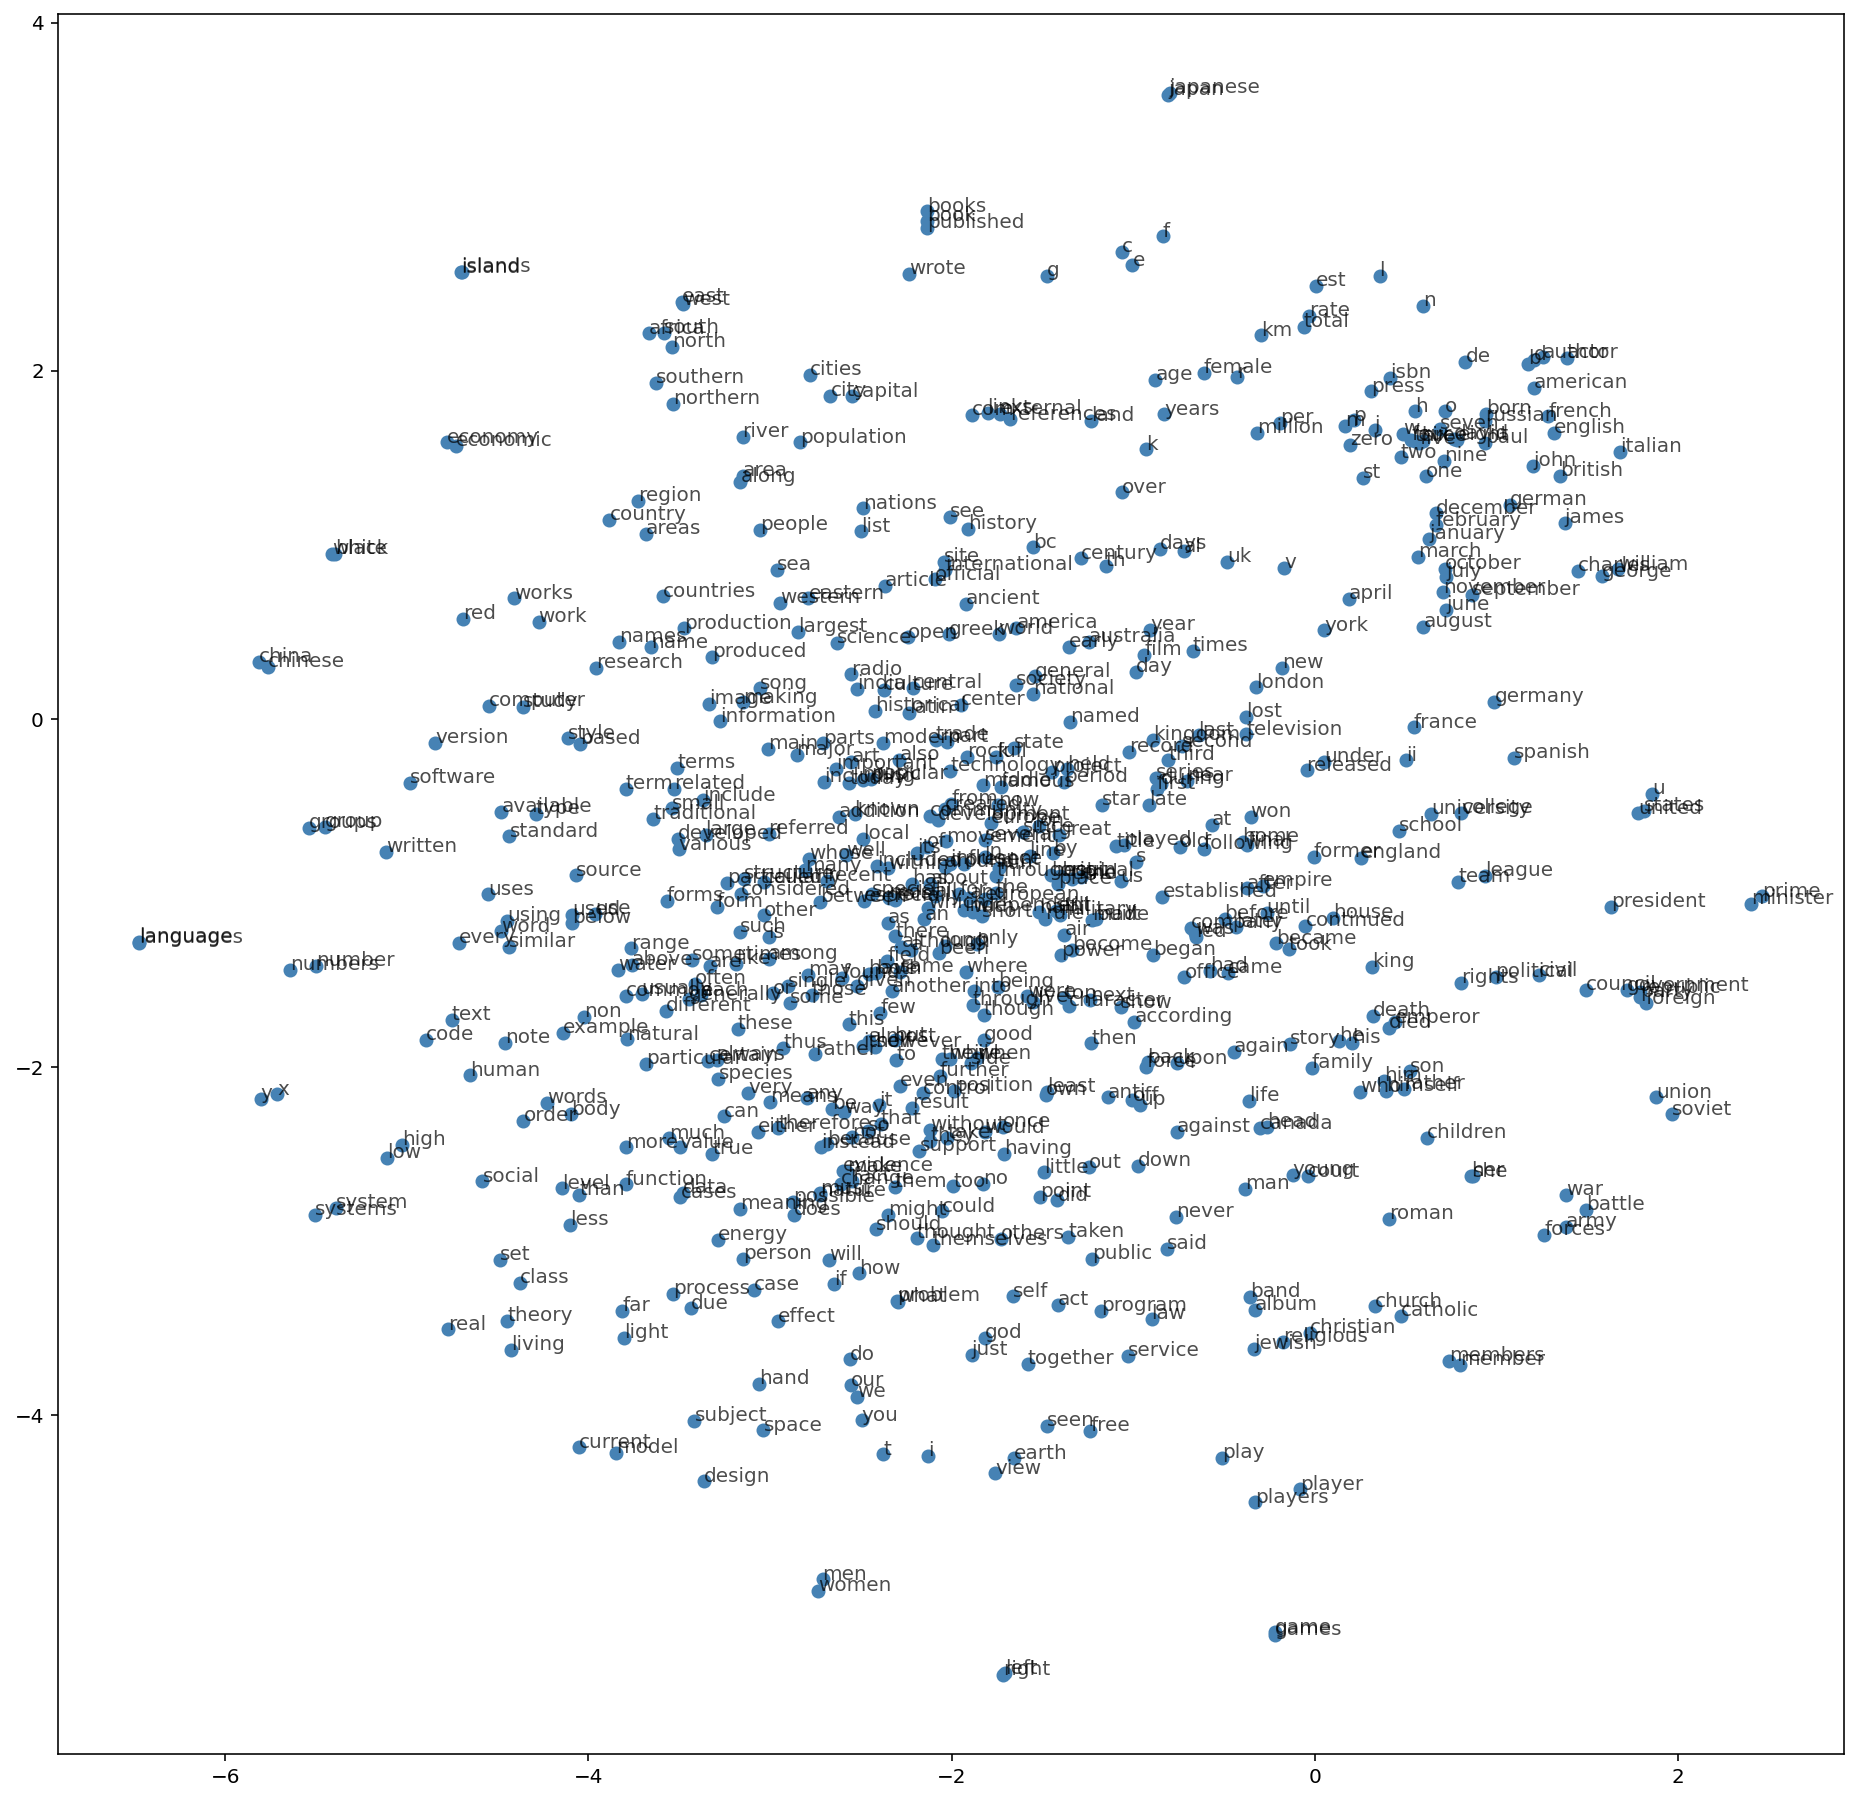

In [28]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)